### Notebook to plot longwave feedback and associated variables from WRF model output.

James Ruppert  
jruppert@ou.edu  
2/15/24

In [63]:
import numpy as np
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import sys
from thermo_functions import *
from precip_class import *
import seaborn as sns
# import xarray as xr
from memory_usage import *
from read_functions import *

In [64]:
# #### Main settings

storm = 'haiyan'
# storm = 'maria'

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
datdir2 = 'post/d02/'

test_str='ctl'#tests[ktest]

figdir = "/home/jamesrup/figures/tc/ens/boxplot/"

time_neglect=12 # time steps from start to neglect

# Number of sample time steps
nt=200 # will be chopped down to max available
# nt=48
# nt=12

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
# nmem = 3
enstag = str(nmem)

In [65]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+test_str+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
dp = (pres[1]-pres[0])*1e2 # Pa
nt=np.min([nt,nt_data-time_neglect])
nx1-=80*2
nx2-=80*2

In [66]:
# Main read loops for 3D (dependent) variables

# Arrays to save variables
dims = (nmem, nt, nx1, nx2)
pclass_all = np.ma.zeros(dims)
cwv_1hr    = np.ma.zeros(dims)
lwacre_1hr = np.ma.zeros(dims)
qrain_1hr  = np.ma.zeros(dims)
rain_1hr   = np.ma.zeros(dims)

t0=time_neglect # neglect the first 12 time steps
t1=t0+nt

print('Running test: ',test_str)

# Loop over ensemble members

for imemb in range(nmem):

    print('Running imemb: ',memb_all[imemb])

    datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
    print(datdir)

    # Stratiform ID
    q_int = read_qcloud(datdir,t0,t1,drop=True) # mm
    pclass = precip_class(q_int)

    # CWV
    varname='PW'
    cwv = var_read_2d(datdir,varname,t0,t1,drop=True) # mm
    # ddtq = np.gradient(lwnet, axis=0) # mm/hr

    # Rain rate
    varname = 'rainrate'
    rain = var_read_2d(datdir,varname,t0,t1,drop=True) # mm/d

    # LWACRE
    lwacre = read_lwacre(datdir,t0,t1,drop=True) # W/m2

    # Save variables for each ens member
    pclass_all[imemb,:,:,:] = pclass
    rain_1hr[imemb,:,:,:]   = rain
    qrain_1hr[imemb,:,:,:]  = q_int[1]
    cwv_1hr[imemb,:,:,:]    = cwv
    lwacre_1hr[imemb,:,:,:] = lwacre

Running test:  ctl
Running imemb:  memb_01
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/post/d02/
Running imemb:  memb_02
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_02/ctl/post/d02/
Running imemb:  memb_03
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_03/ctl/post/d02/
Running imemb:  memb_04
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_04/ctl/post/d02/
Running imemb:  memb_05
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_05/ctl/post/d02/
Running imemb:  memb_06
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_06/ctl/post/d02/
Running imemb:  memb_07
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_07/ctl/post/d02/
Running imemb:  memb_08
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_08/ctl/post/d02/
Running imemb:  memb_09
/ourdisk/hpc/radclouds/auto_a

In [67]:
# Smoothing function
# def time_smooth_var(var, nwindow):
#     data_xr = xr.DataArray(var,
#                             coords={'test':np.arange(ntest), 'memb':memb_nums, 'time':np.arange(nt),
#                             'y':np.arange(nx1), 'x':np.arange(nx2)},
#                             dims=['test','memb','time','y','x'])
#     data_smooth = data_xr.rolling(time=nwindow, center=True).mean()
#     return data_smooth.to_masked_array()

In [68]:
# # ### Run binning

# def get_kstrat_cells(var_in, strat):
#     var_indexed = []
#     nstrat=6
#     for kstrat in range(nstrat):
#         indices = (strat == kstrat).nonzero()
#         indexed_var = var_in[indices[0],indices[1],indices[2],indices[3]]
#         var_indexed.append(indexed_var)
#     return var_indexed

In [69]:
# qrain_indexed_1hr    = get_kstrat_cells(qrain_1hr, strat_all)
# cwv_indexed_1hr      = get_kstrat_cells(cwv_1hr, strat_all)
# lwacre_indexed_1hr   = get_kstrat_cells(lwacre_1hr, strat_all)
# # vmfu_indexed_1hr     = get_kstrat_cells(vmfu_1hr, strat_all)
# # condh_indexed_1hr    = get_kstrat_cells(condh_1hr, strat_all)
# lwfeedb1_indexed_1hr = get_kstrat_cells(np.absolute(lwacre_1hr)/qrain_1hr, strat_all)
# # lwfeedb2_indexed_1hr = get_kstrat_cells(np.absolute(lwacre_1hr)/vmfu_1hr , strat_all)
# # lwfeedb3_indexed_1hr = get_kstrat_cells(np.absolute(lwacre_1hr)/condh_1hr, strat_all)
# # lwfeedb1_indexed_1hr = get_kstrat_cells(lwacre_1hr/qrain_1hr, strat_all)
# # lwfeedb2_indexed_1hr = get_kstrat_cells(lwacre_1hr/vmfu_1hr , strat_all)
# # lwfeedb3_indexed_1hr = get_kstrat_cells(lwacre_1hr/condh_1hr, strat_all)

In [70]:
# # Mask out where values go infinite
# for iclass in range(6):
#     # lwfeedb1_indexed_1hr[ivar] = np.ma.masked_where(np.bitwise_or((lwacre_indexed_1hr[ivar] == 0), (qrain_indexed_1hr[ivar] == 0)),
#     #     lwfeedb1_indexed_1hr[ivar], copy=False)
#     lwfeedb1_indexed_1hr[iclass] = np.ma.masked_where((qrain_indexed_1hr[iclass] == 0), lwfeedb1_indexed_1hr[iclass], copy=False)

In [71]:
# Mean class areas
npts = nmem*nt*nx1*nx2
nclass=6
area_frac = np.zeros(nclass)
for iclass in range(nclass):
    ind = (pclass_all == iclass).nonzero()
    area_frac[iclass] = ind[0].size/npts

In [72]:
# ### PClass Masking

def kclass_masking(var_in, pclass):
    nclass=6
    # var_out = np.repeat(var_in, 6, axis=(0,))
    shape=var_in.shape
    var_out = np.ma.zeros((nclass,shape[0],shape[1]))
    for iclass in range(nclass):
        # var_out[iclass] = np.mean(var_in, axis=(2,3), np.where(pclass == iclass))
        var_tmp = np.ma.masked_where((pclass != iclass), var_in, copy=True)
        var_out[iclass] = np.ma.mean(var_tmp, axis=(2,3))
    return var_out

In [73]:
qrain_masked = kclass_masking(qrain_1hr, pclass_all)
rain_masked = kclass_masking(rain_1hr, pclass_all)
cwv_masked = kclass_masking(cwv_1hr, pclass_all)
lwacre_masked = kclass_masking(lwacre_1hr, pclass_all)

In [74]:
lwfeedback1 = lwacre_masked / qrain_masked
lwfeedback2 = lwacre_masked / rain_masked

In [75]:
# ---
# ### Plotting routines

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 11}

matplotlib.rc('font', **font)

In [76]:
# Global boxplot settings

def create_boxplot(invar, title_tag, fig_tag, units, yscale='linear'):

    c_name = ['Non-precip', 'Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    cmap = ['white', 'teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    # c_name = ['Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    # cmap = ['teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    sns.set_palette(cmap)

    fig = plt.figure(figsize=(5.5,4),dpi=300)
    # fig.set_facecolor('white')
    ax = fig.subplots(nrows=1, ncols=1)
    sns.boxplot([invar[0], invar[1], invar[2], invar[3], invar[4], invar[5]],
    # sns.boxplot([invar[1], invar[2], invar[3], invar[4], invar[5]],
                width=0.7, showmeans=True, #log_scale=log_scale,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"})

    ax.set_yscale(yscale)
    ax.set_xticklabels(c_name)
    plt.ylabel(units)#, weight='bold')
    plt.title("Class-averaged "+title_tag)#, weight='bold')
    plt.savefig(figdir+fig_tag+test_str+'.png',dpi=200, facecolor='white', bbox_inches='tight', pad_inches=0.2)

In [77]:
def create_boxplot_noclear(invar, title_tag, fig_tag, units, yscale='linear'):

    # c_name = ['Non-precip', 'Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    # cmap = ['white', 'teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    c_name = ['Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    cmap = ['teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    sns.set_palette(cmap)

    fig = plt.figure(figsize=(5.5,4),dpi=300)
    # fig.set_facecolor('white')
    ax = fig.subplots(nrows=1, ncols=1)
    # sns.boxplot([invar[0], invar[1], invar[2], invar[3], invar[4], invar[5]],
    sns.boxplot([invar[1], invar[2], invar[3], invar[4], invar[5]],
                width=0.7, showmeans=True, #log_scale=log_scale,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"})

    ax.set_yscale(yscale)
    # ax.set_ylim([1e-2,1e14])
    ax.set_xticklabels(c_name)
    plt.ylabel(units)#, weight='bold')
    plt.title("Class-averaged "+title_tag)#, weight='bold')
    plt.savefig(figdir+fig_tag+test_str+'.png',dpi=200, facecolor='white', bbox_inches='tight', pad_inches=0.2)

RUNNING CWV


/tmp/ipykernel_447/3863322345.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


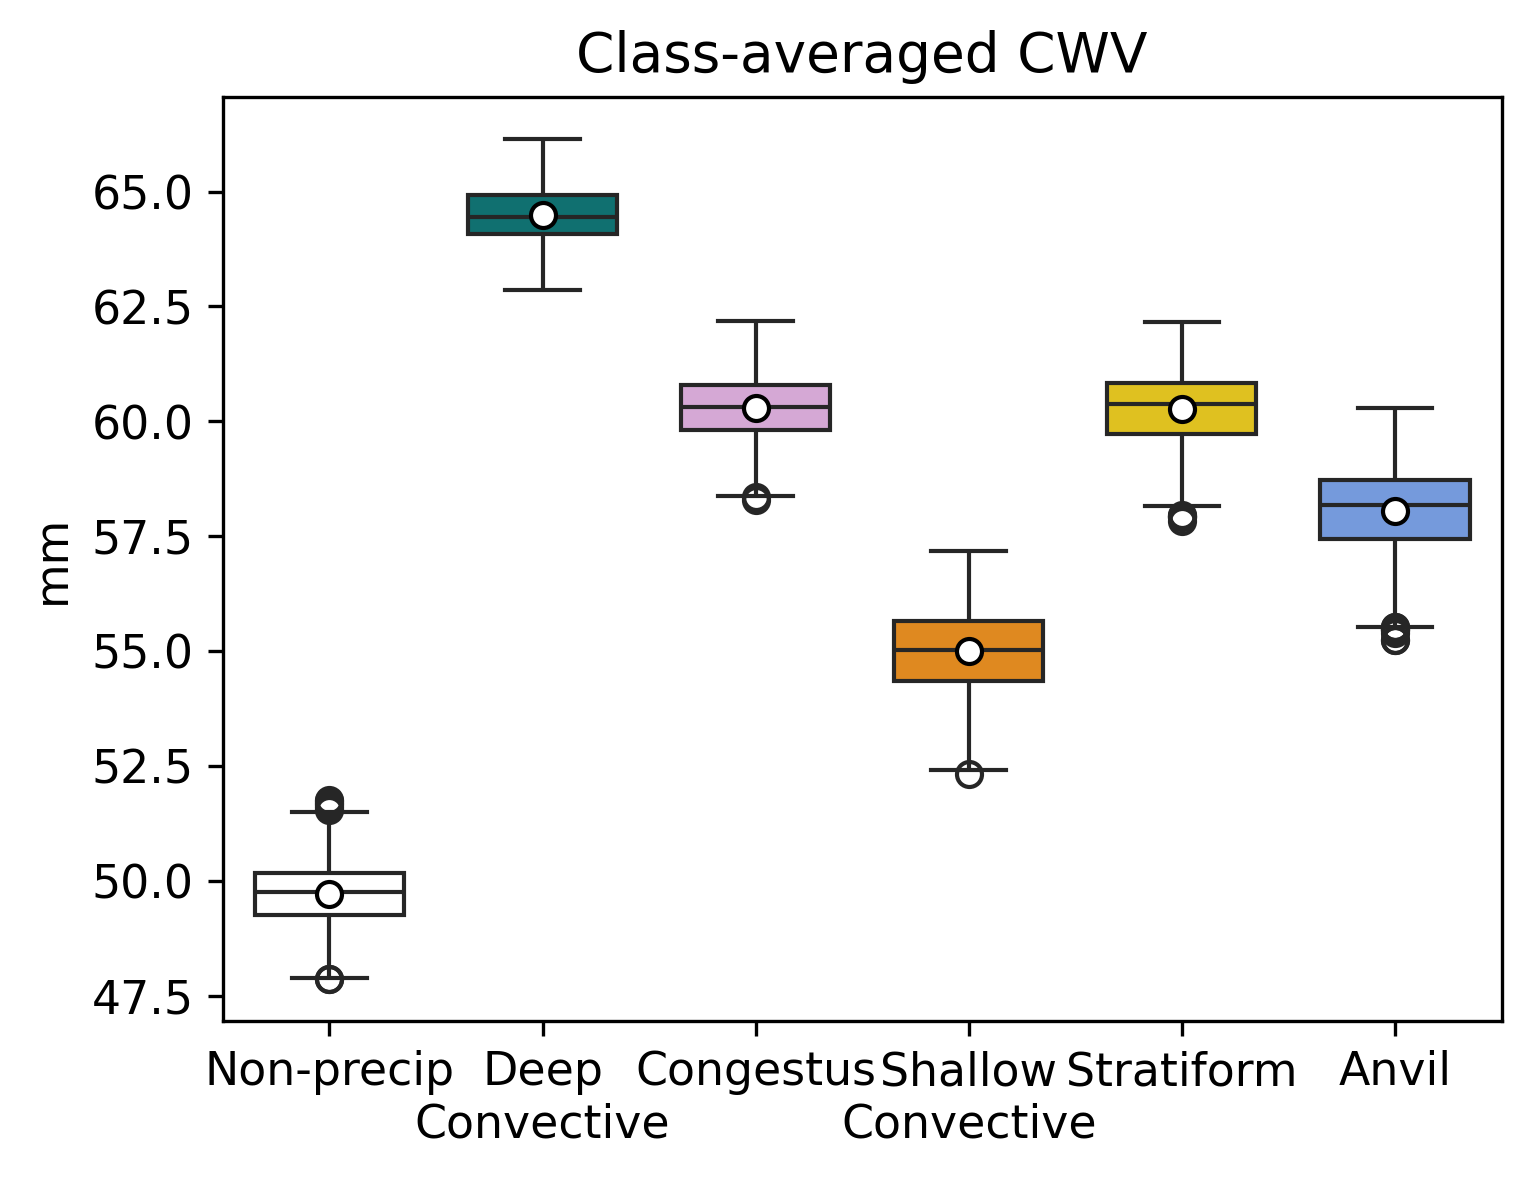

In [78]:
print("RUNNING CWV")

units = "mm"
title_tag = "CWV"
fig_tag = "cwv"
create_boxplot(np.reshape(cwv_masked,(6,nmem*nt)), title_tag, fig_tag,  units)

RUNNING LWACRE


/tmp/ipykernel_447/3863322345.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


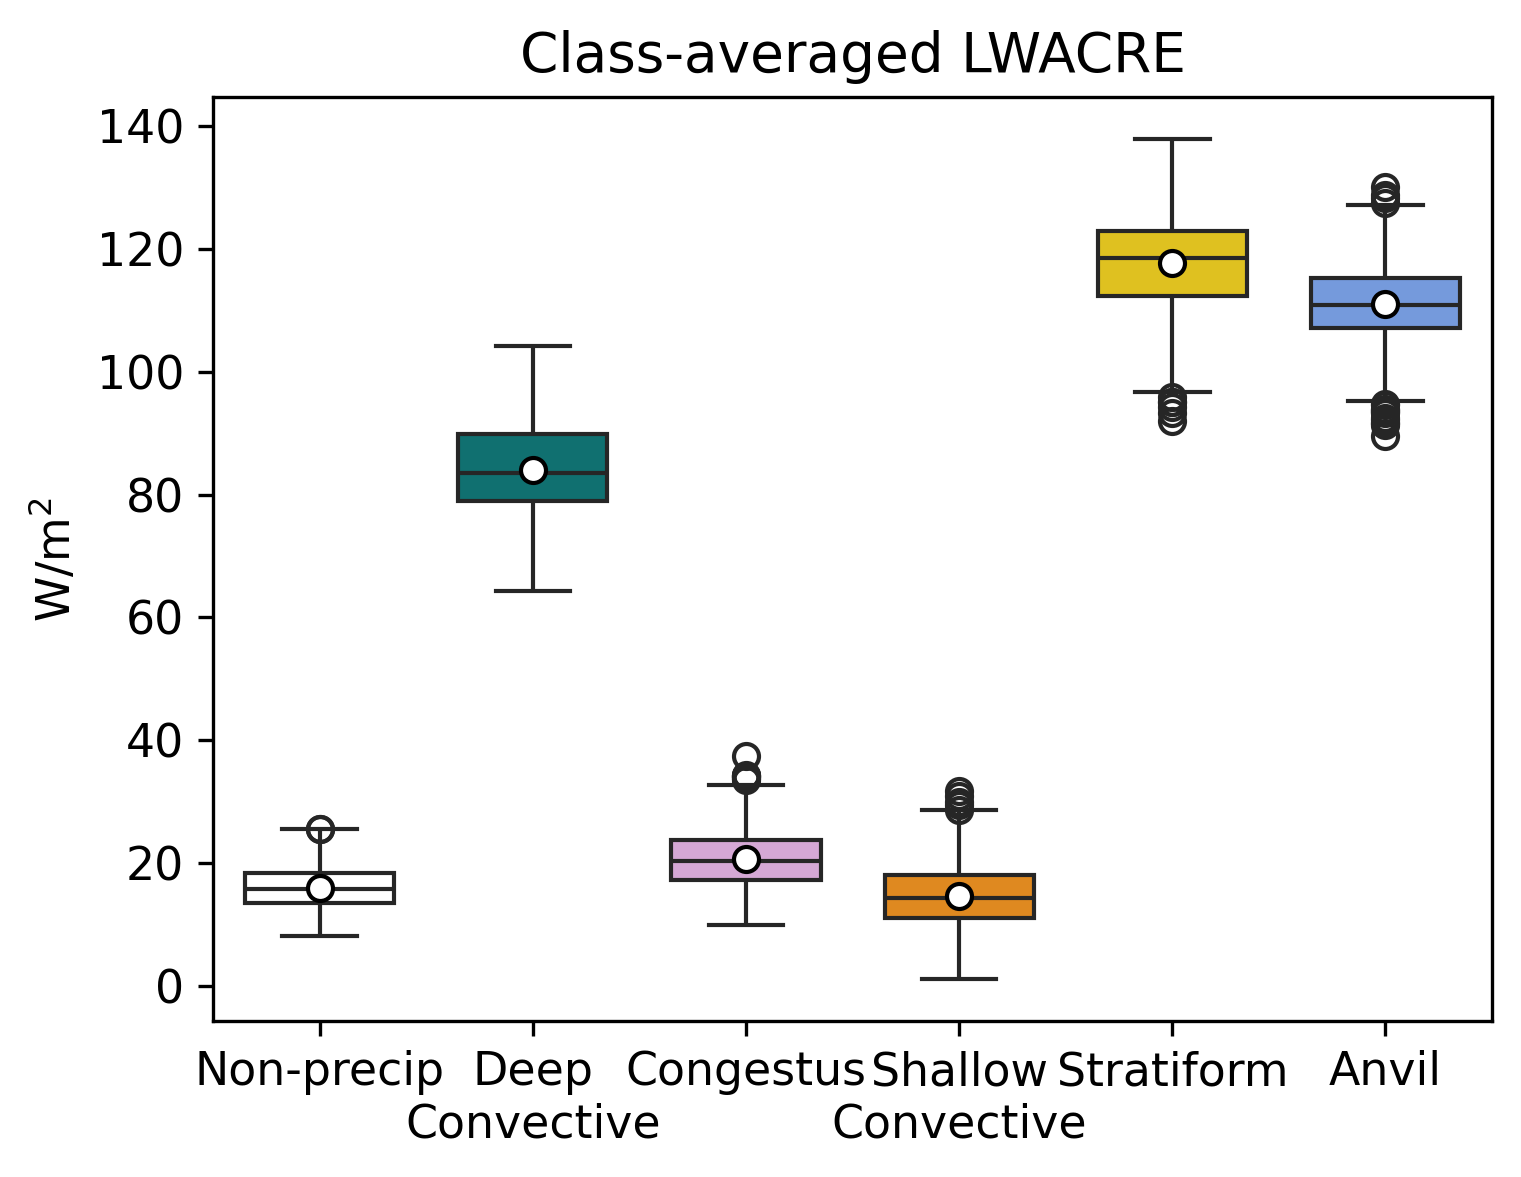

In [79]:
print("RUNNING LWACRE")

units = "W/m$^2$"
title_tag = "LWACRE"
fig_tag = "lwacre"
create_boxplot(np.reshape(lwacre_masked,(6,nmem*nt)), title_tag, fig_tag, units)

print("DONE")

In [80]:
# print("RUNNING VMFup")

# units = "kg/m/s"
# title_tag = "VMFup"
# fig_tag = "vmfu"
# create_boxplot(vmfu_indexed_1hr, title_tag, fig_tag, units, yscale='log')

# print("DONE")
# print("RUNNING CONDH")

# title_tag = "CONDH"
# units = "mm/day"
# fig_tag = "condh"
# create_boxplot(condh_indexed_1hr, title_tag, fig_tag, units, yscale='log')

RUNNING QRAIN


/tmp/ipykernel_447/941247814.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


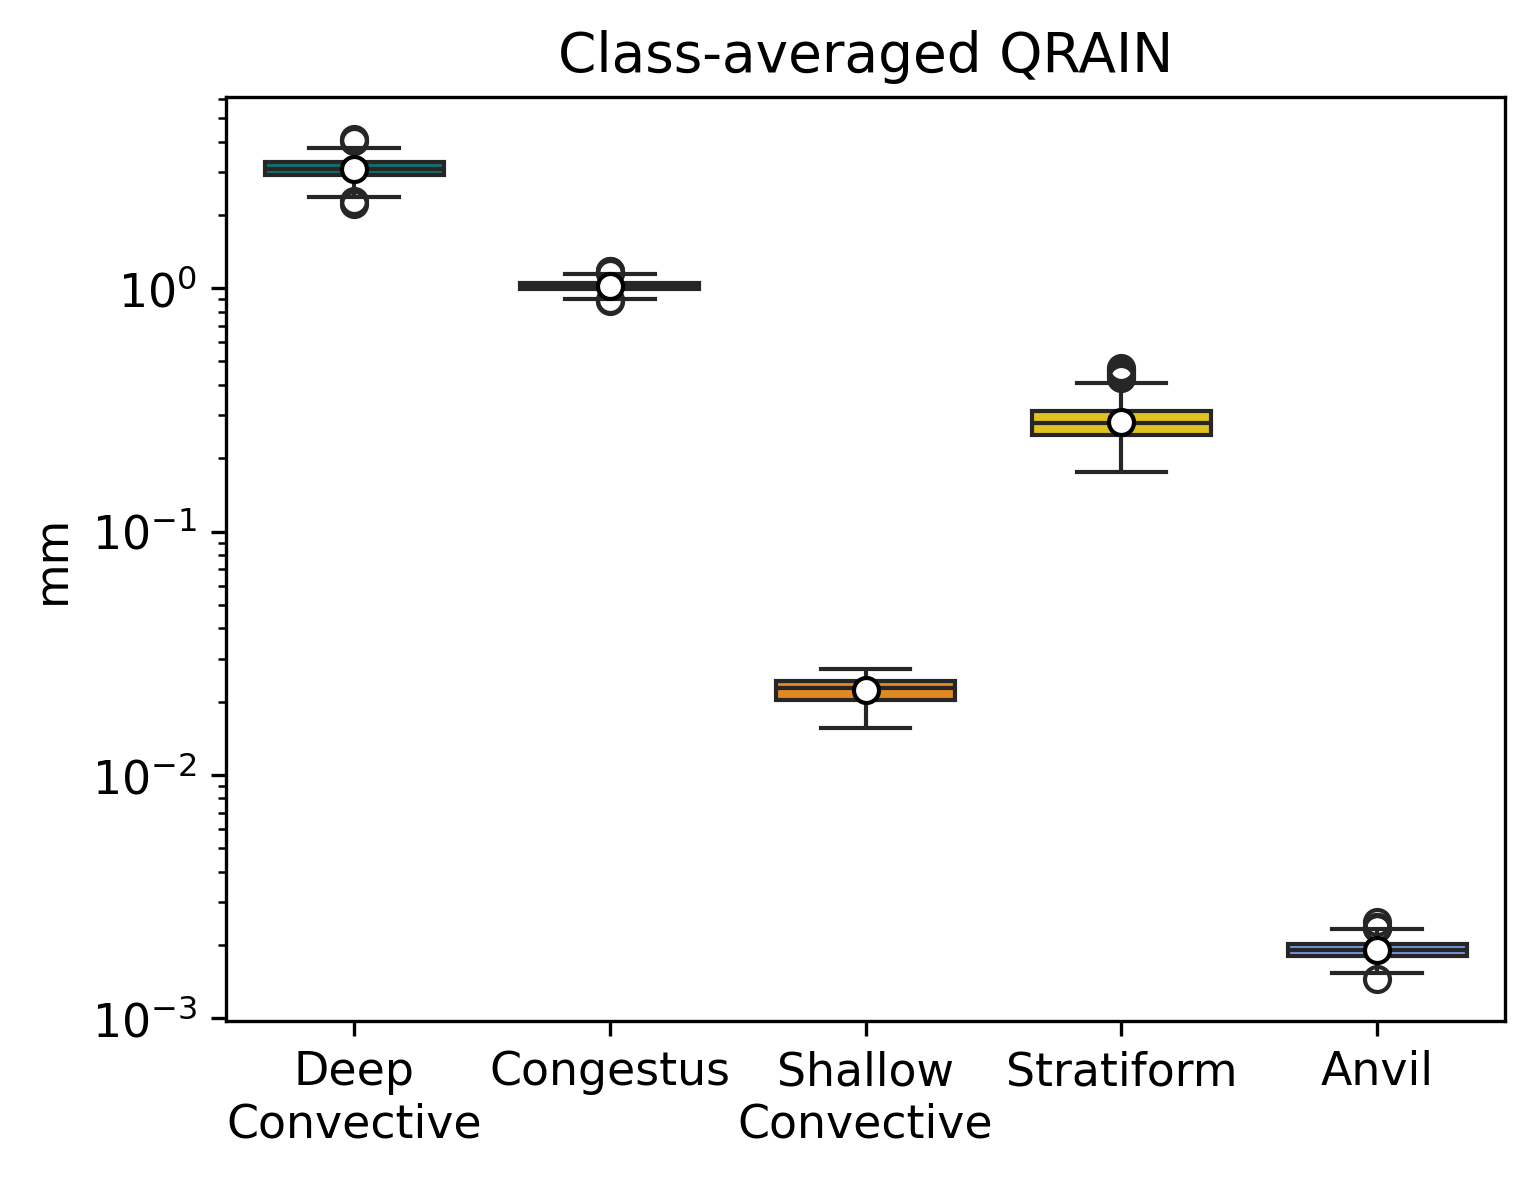

In [81]:
print("RUNNING QRAIN")

units = "mm"
title_tag = "QRAIN"
fig_tag = "qrain"
create_boxplot_noclear(np.reshape(qrain_masked,(6,nmem*nt)), title_tag, fig_tag, units, yscale="log")

print("DONE")

RUNNING RAIN


/tmp/ipykernel_447/941247814.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


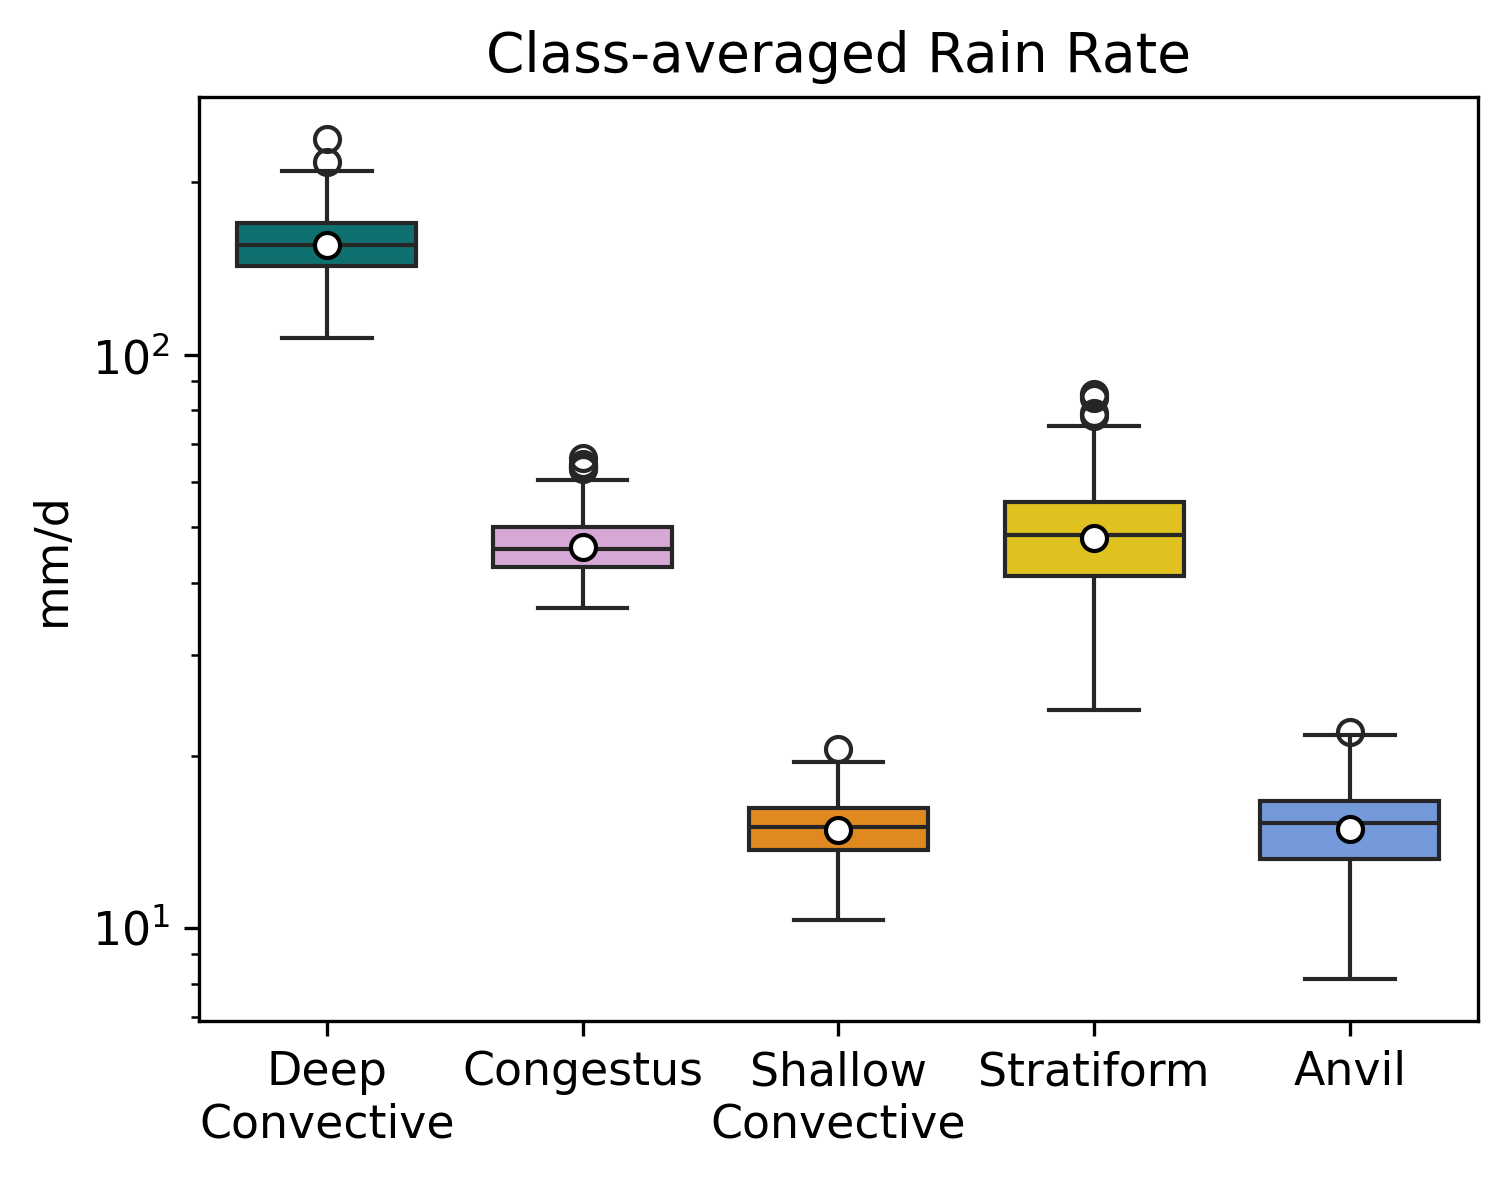

In [82]:
print("RUNNING RAIN")

units = "mm/d"
title_tag = "Rain Rate"
fig_tag = "rain"
create_boxplot_noclear(np.reshape(rain_masked,(6,nmem*nt)), title_tag, fig_tag, units, yscale="log")

print("DONE")

RUNNING RAIN


/tmp/ipykernel_447/941247814.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


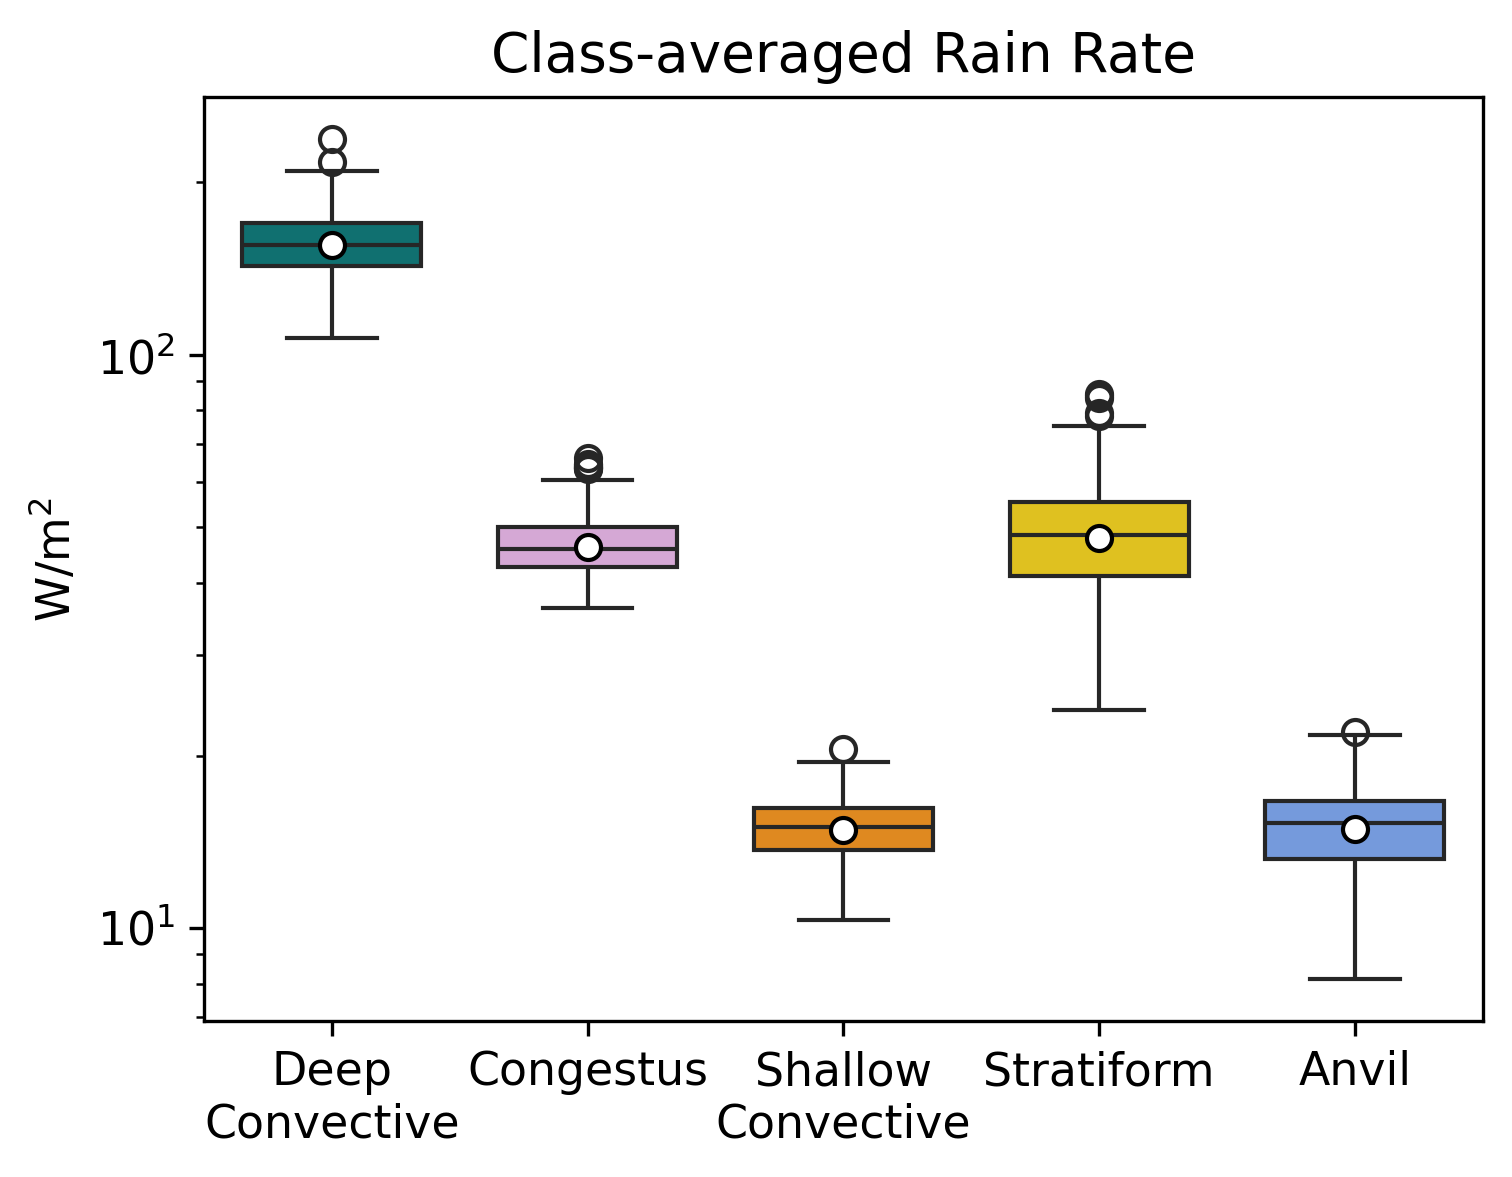

In [83]:
print("RUNNING RAIN")

lv0=2.5e6
rain_wm2 = rain_masked*lv0/(24*3600)

# units = "mm/d"
units = "W/m$^2$"
title_tag = "Rain Rate"
fig_tag = "rain"
create_boxplot_noclear(np.reshape(rain_masked,(6,nmem*nt)), title_tag, fig_tag, units, yscale="log")

print("DONE")

In [84]:
# print("RUNNING LWFB1")

# # Local LW Feedback
# units = "W/m$^2$ / mm"
# title_tag = "LWACRE/QRAIN"
# fig_tag = "lwfdb_qrain"
# create_boxplot_noclear(lwfeedb1_indexed_1hr, title_tag, fig_tag, units, yscale="log")

# print("DONE")

RUNNING LWFB1


/tmp/ipykernel_447/941247814.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


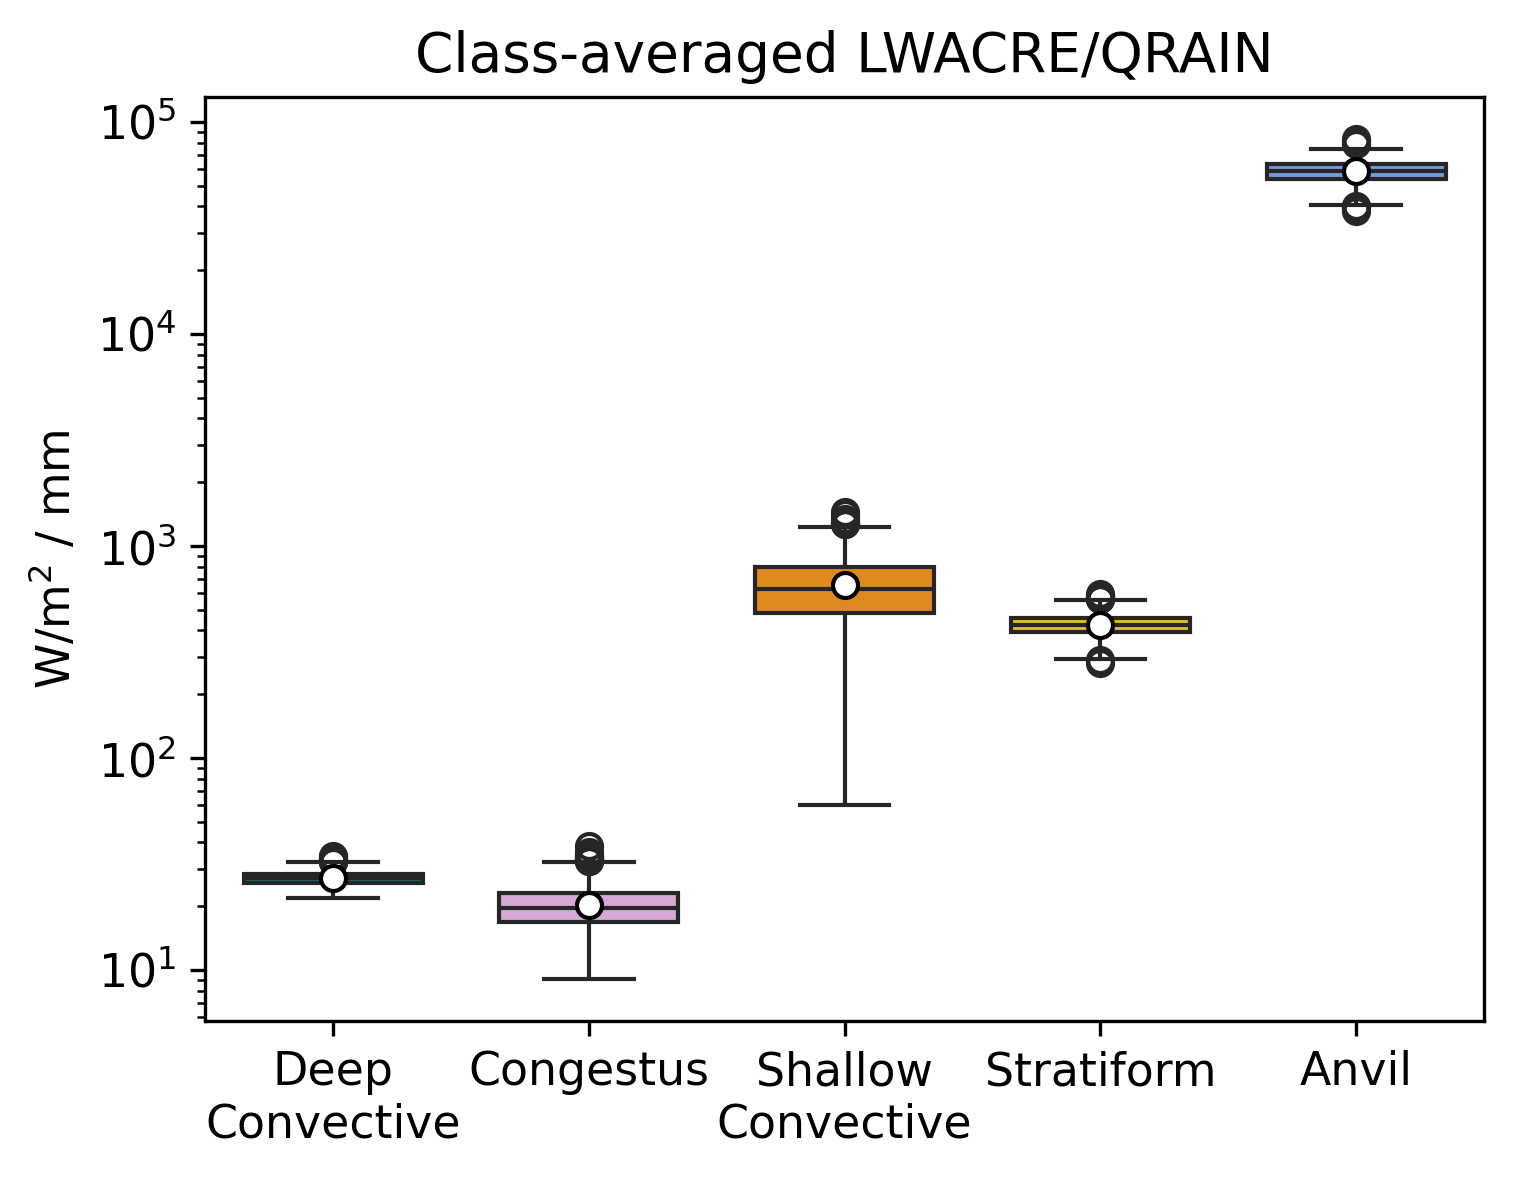

In [85]:
print("RUNNING LWFB1")

# Local LW Feedback
units = "W/m$^2$ / mm"
title_tag = "LWACRE/QRAIN"
fig_tag = "lwfdb_qrain"
create_boxplot_noclear(np.reshape(lwfeedback1,(6,nmem*nt)), title_tag, fig_tag, units, yscale="log")

print("DONE")

RUNNING LWFB1


/tmp/ipykernel_447/941247814.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


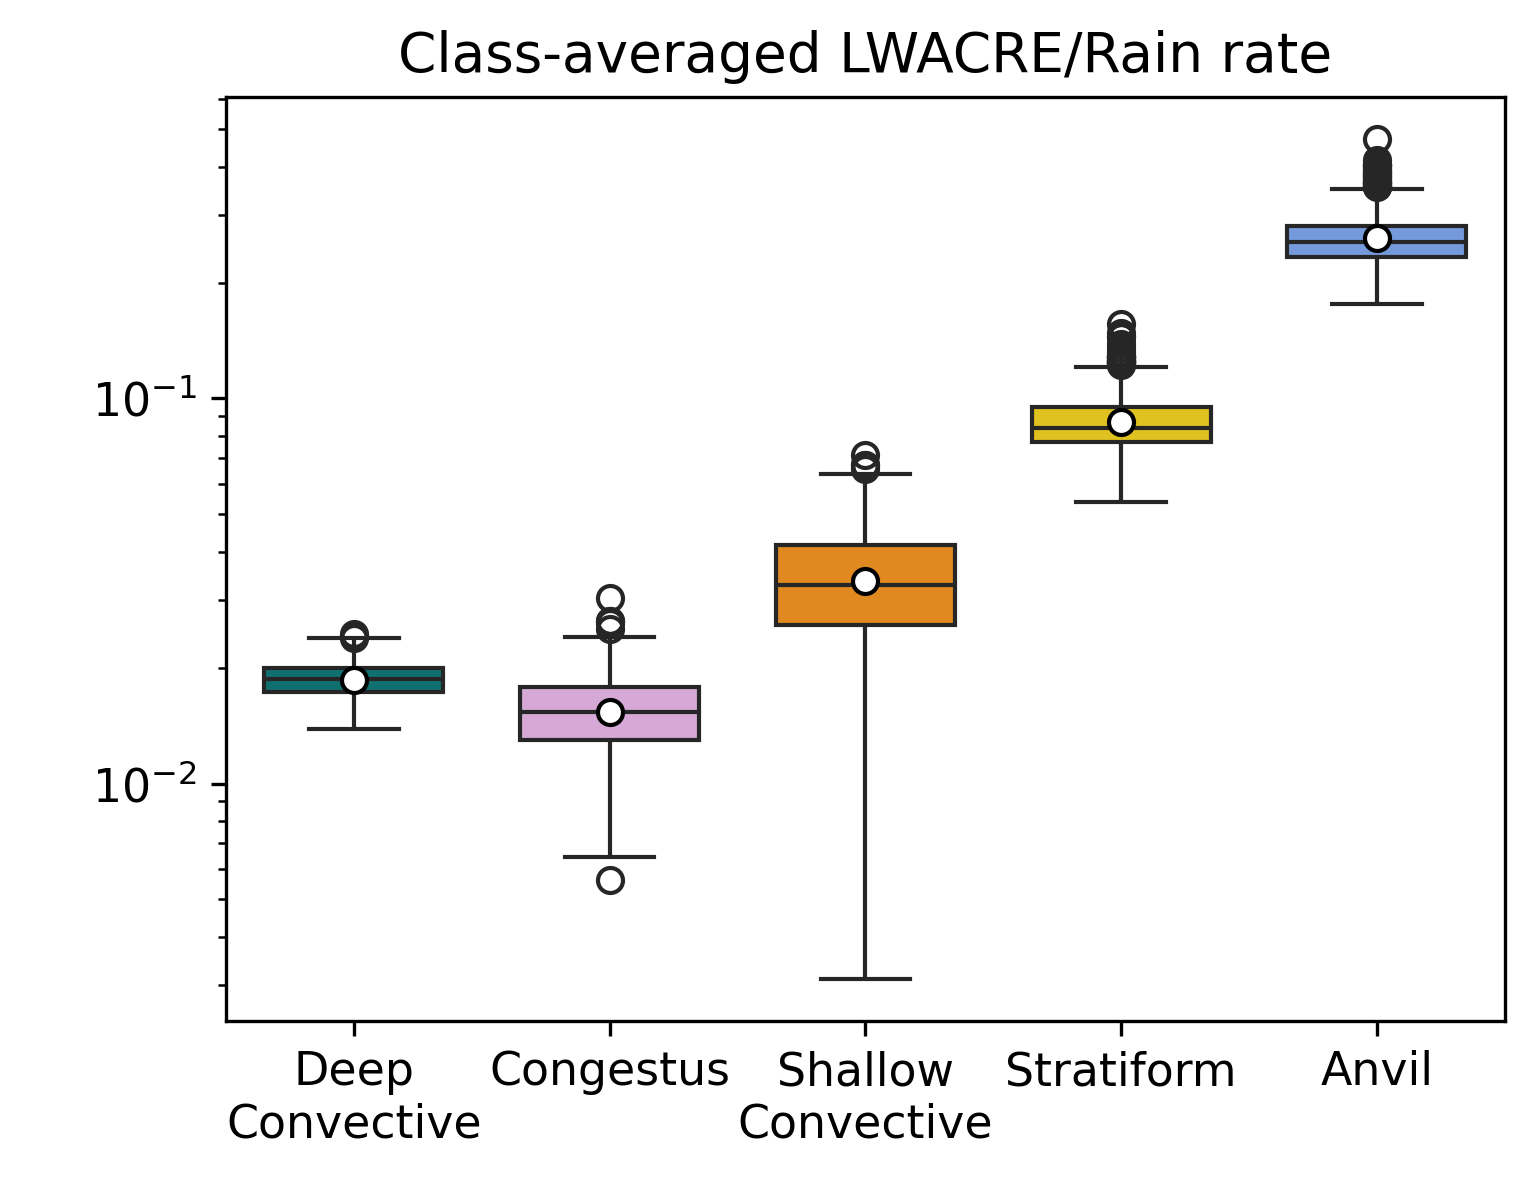

In [86]:
print("RUNNING LWFB1")

# Use W/m2 for rainfall
lv0=2.5e6
lwfeedback2 = lwacre_masked / (rain_masked*lv0/(24*3600))

# Local LW Feedback
# units = "W/m$^2$ / mm/d"
units = " "
title_tag = "LWACRE/Rain rate"
fig_tag = "lwfdb_rain"
create_boxplot_noclear(np.reshape(lwfeedback2,(6,nmem*nt)), title_tag, fig_tag, units, yscale="log")

print("DONE")

RUNNING LWFB1*AREA


/tmp/ipykernel_447/941247814.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


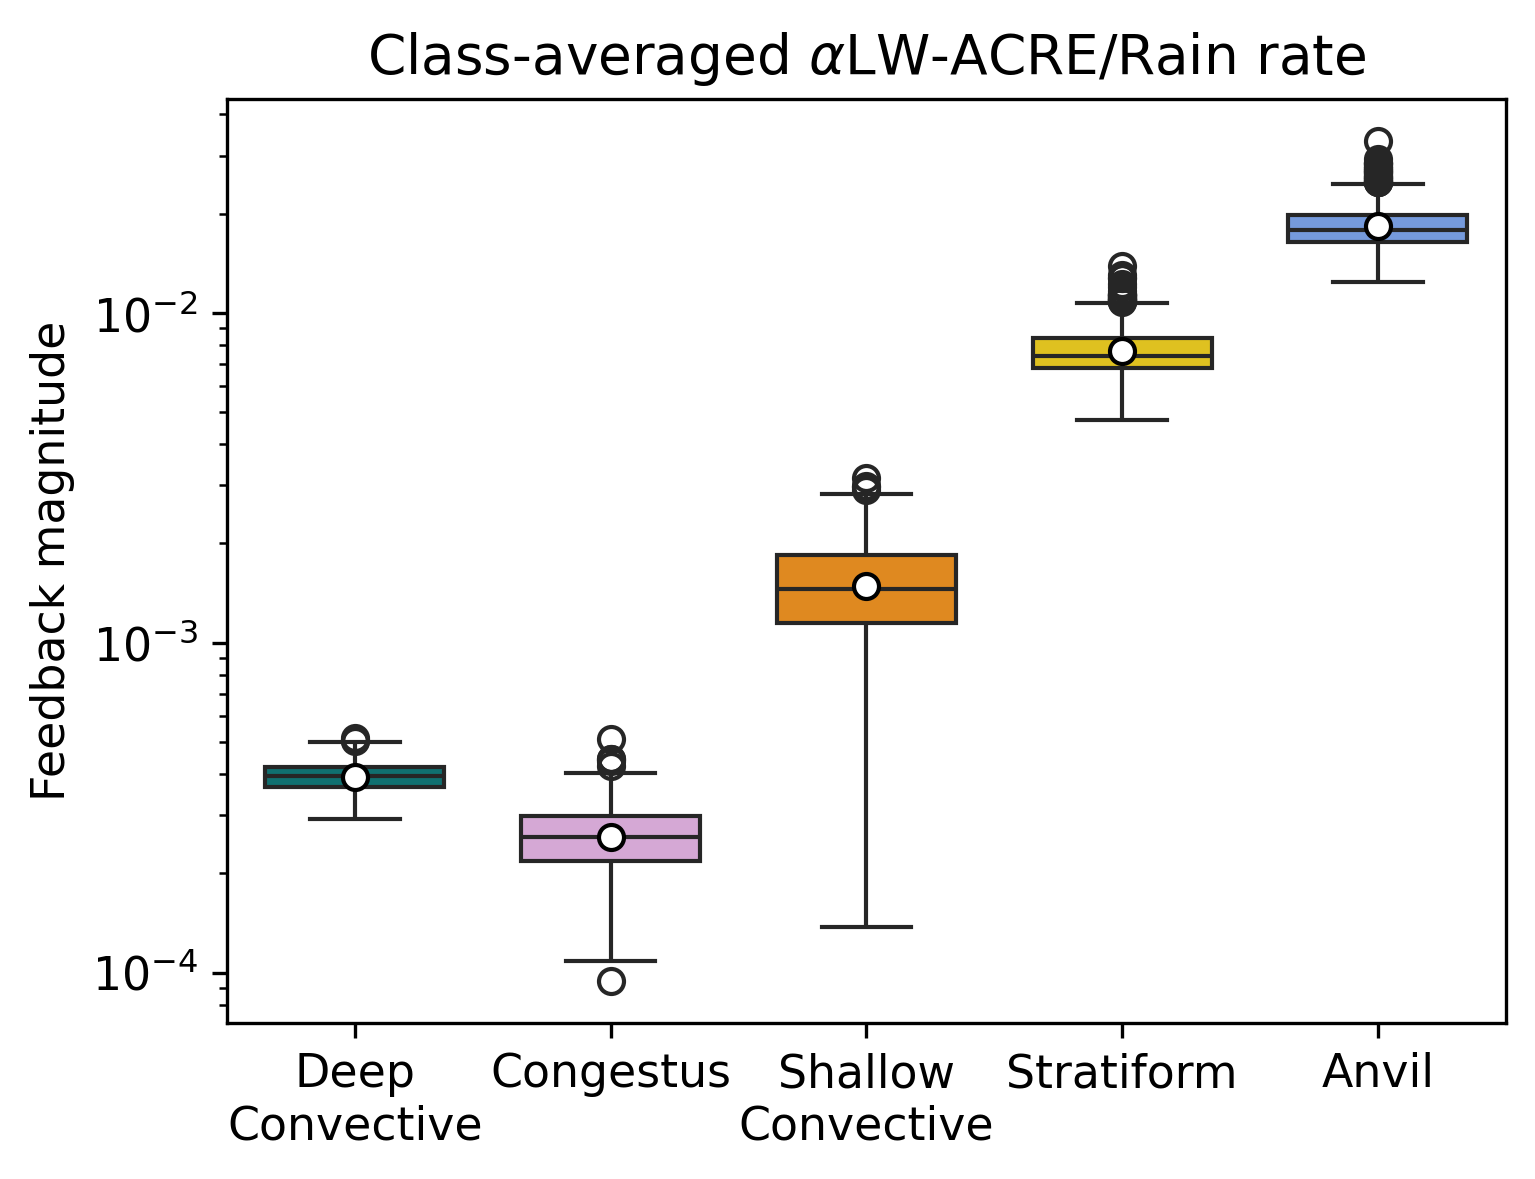

In [87]:
print("RUNNING LWFB1*AREA")

# Use W/m2 for rainfall
lv0=2.5e6
lwfeedback2 = lwacre_masked*area_frac[:,np.newaxis,np.newaxis] / (rain_masked*lv0/(24*3600))

# Local LW Feedback
# units = "W/m$^2$ / mm/d"
units = "Feedback magnitude"
title_tag = r"$\alpha$"+"LW-ACRE/Rain rate"
fig_tag = "lwfdb_rain"
create_boxplot_noclear(np.reshape(lwfeedback2,(6,nmem*nt)), title_tag, fig_tag, units, yscale="log")

print("DONE")